In [2]:
from Bio import AlignIO
from collections import Counter
from scipy.stats import chisquare

# Parameters
aligned_fasta_path = "Galaxy3-[MAFFT on data 2].fasta"
start_motif = "CCACT"
end_motif = "ACCCGCTGGT"

# Step 1: Load aligned FASTA
alignment = AlignIO.read(aligned_fasta_path, "fasta")

# Step 2: Extract region between motifs
sliced_sequences = []

for rec in alignment:
    full_seq = str(rec.seq).replace("-", "").upper()
    start_idx = full_seq.find(start_motif)
    end_idx = full_seq.find(end_motif)

    if start_idx != -1 and end_idx != -1 and start_idx < end_idx:
        between_seq = full_seq[start_idx + len(start_motif): end_idx]
        if 1 <= len(between_seq) <= 10:
            sliced_sequences.append(between_seq)

print(f"✅ Extracted {len(sliced_sequences)} sequences between motifs.")

# Step 3: Classify into 24 construct types
def classify_construct(seq):
    c_prefix = 0
    while c_prefix < 2 and c_prefix < len(seq) and seq[c_prefix] == 'C':
        c_prefix += 1
    n_len = len(seq) - c_prefix
    if 1 <= n_len <= 8:
        return f"{'C'*c_prefix}N{n_len}"
    return None

construct_counts = Counter(classify_construct(seq) for seq in sliced_sequences if classify_construct(seq) is not None)


# Step 4: Define construct types and observed counts
all_constructs = [f"N{i}" for i in range(1, 9)] + \
                 [f"CN{i}" for i in range(1, 9)] + \
                 [f"CCN{i}" for i in range(1, 9)]

observed = [construct_counts.get(label, 0) for label in all_constructs]
total_observed = sum(observed)

# Step 5: Build refined expected frequencies
weights = {label: 0.0 for label in all_constructs}

# Contributions from Nn
for n in range(1, 9):
    if n == 1:
        weights["N1"] += 1.0
    else:
        weights[f"N{n}"] += 0.75
        weights[f"CN{n-1}"] += 0.1875
        if n >= 3:
            weights[f"CCN{n-2}"] += 0.0625

# Contributions from CNn
for n in range(1, 9):
    weights[f"CN{n}"] += 0.75
    if n >= 2:
        weights[f"CCN{n-1}"] += 0.25

# Contributions from CCNn
for n in range(1, 9):
    weights[f"CCN{n}"] += 1.0

# Step 6: Normalize weights to match total observed
total_weight = sum(weights.values())
scaling_factor = total_observed / total_weight
expected = [weights[label] * scaling_factor for label in all_constructs]

# Step 7: Chi-square test
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

# Step 8: Print results
print(f"\n📊 Chi-square test result:")
print(f"  Statistic = {chi2_stat:.2f}")
print(f"  P-value   = {p_value:.4g}")

print("\n📦 Observed vs Expected Counts:")
for label, obs, exp in zip(all_constructs, observed, expected):
    print(f"{label}: observed = {obs}, expected = {exp:.2f}")


✅ Extracted 331 sequences between motifs.

📊 Chi-square test result:
  Statistic = 516.49
  P-value   = 1.301e-94

📦 Observed vs Expected Counts:
N1: observed = 4, expected = 13.97
N2: observed = 2, expected = 10.48
N3: observed = 12, expected = 10.48
N4: observed = 5, expected = 10.48
N5: observed = 15, expected = 10.48
N6: observed = 55, expected = 10.48
N7: observed = 14, expected = 10.48
N8: observed = 1, expected = 10.48
CN1: observed = 2, expected = 13.10
CN2: observed = 6, expected = 13.10
CN3: observed = 6, expected = 13.10
CN4: observed = 3, expected = 13.10
CN5: observed = 34, expected = 13.10
CN6: observed = 58, expected = 13.10
CN7: observed = 10, expected = 13.10
CN8: observed = 2, expected = 10.48
CCN1: observed = 1, expected = 18.34
CCN2: observed = 2, expected = 18.34
CCN3: observed = 13, expected = 18.34
CCN4: observed = 21, expected = 18.34
CCN5: observed = 36, expected = 18.34
CCN6: observed = 26, expected = 18.34
CCN7: observed = 1, expected = 17.47
CCN8: observed =

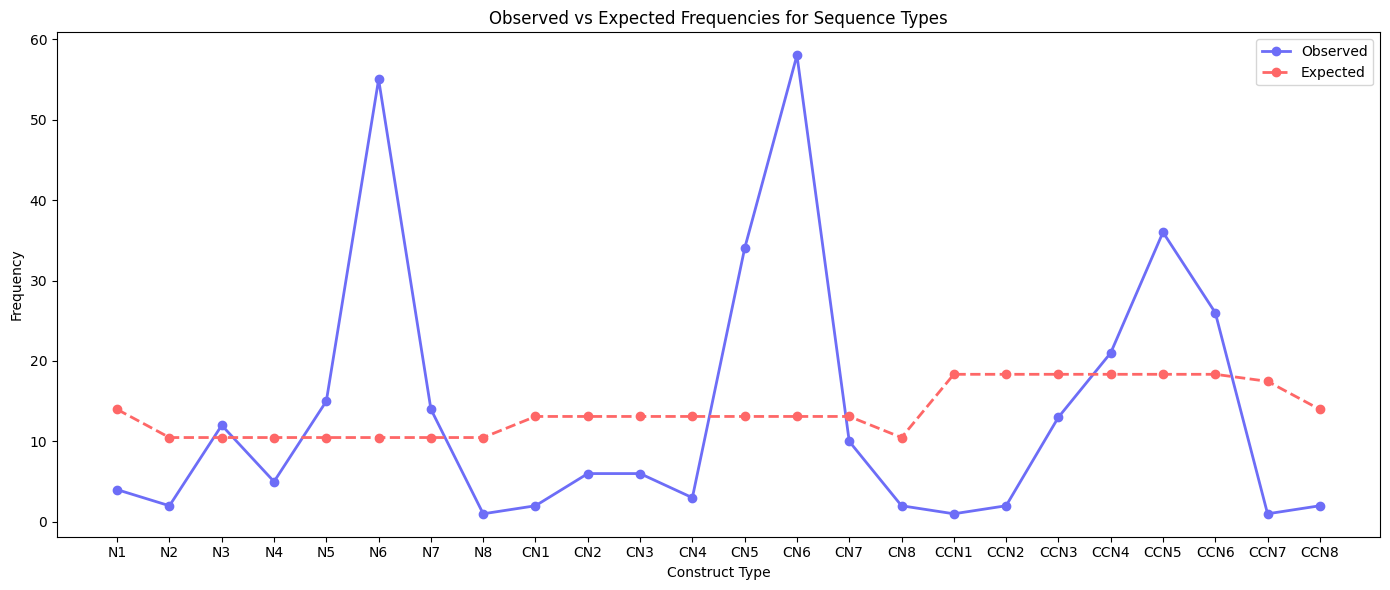

In [36]:
import matplotlib.pyplot as plt

# Normalized RGB colors
group_colors_rgb = {
    2: (109/255, 109/255, 247/255),  # navy
    4: (254/255, 103/255, 103/255)   # red
}

# Step 9: Line plot of observed vs expected frequencies
plt.figure(figsize=(14, 6))

# Plot observed frequencies (navy)
plt.plot(all_constructs, observed, marker='o', label='Observed',
         linewidth=2, color=group_colors_rgb[2])

# Plot expected frequencies (red)
plt.plot(all_constructs, expected, marker='o', linestyle='--', label='Expected',
         linewidth=2, color=group_colors_rgb[4])

# Axis labels and title
plt.xlabel("Construct Type")
plt.ylabel("Frequency")
plt.title("Observed vs Expected Frequencies for Sequence Types")

# Legend and layout
plt.legend()
plt.tight_layout()
plt.savefig("N Obs vs Exp", dpi=300, bbox_inches="tight")
plt.show()


In [11]:
from collections import Counter
from scipy.stats import chisquare

# Step 1: Count prefix categories
prefix_counts = {'N': 0, 'CN': 0, 'CCN': 0}

for seq in sliced_sequences:
    if seq.startswith('CC'):
        prefix_counts['CCN'] += 1
    elif seq.startswith('C'):
        prefix_counts['CN'] += 1
    else:
        prefix_counts['N'] += 1

# Step 2: Observed counts
n_obs = prefix_counts['N']
cn_obs = prefix_counts['CN']
ccn_obs = prefix_counts['CCN']

# Step 3: Expected counts based on design + spillover
total = n_obs + cn_obs + ccn_obs
x = total / 3  # designed fraction per group

n_exp = x * 0.75
cn_exp = x + x * 0.1875
ccn_exp = x + x * 0.0625

total=n_exp+cn_exp+ccn_exp

print(n_exp)
print(cn_exp)
print(ccn_exp)
print(total)

# Step 4: Run chi-square test
stat, p = chisquare([n_obs, cn_obs, ccn_obs], f_exp=[n_exp, cn_exp, ccn_exp])

# Step 5: Output
print(f"\n📊 Chi-square test (prefix-based, design + spillover model):")
print(f"  Statistic = {stat:.2f}")
print(f"  P-value   = {p:.4g}")

print(f"\n📦 Observed counts:")
print(f"  N:   {n_obs}")
print(f"  CN:  {cn_obs}")
print(f"  CCN: {ccn_obs}")

print(f"\n📈 Expected counts:")
print(f"  N:   {n_exp:.2f}")
print(f"  CN:  {cn_exp:.2f}")
print(f"  CCN: {ccn_exp:.2f}")


82.75
131.02083333333331
117.22916666666666
331.0

📊 Chi-square test (prefix-based, design + spillover model):
  Statistic = 10.45
  P-value   = 0.005382

📦 Observed counts:
  N:   108
  CN:  121
  CCN: 102

📈 Expected counts:
  N:   82.75
  CN:  131.02
  CCN: 117.23


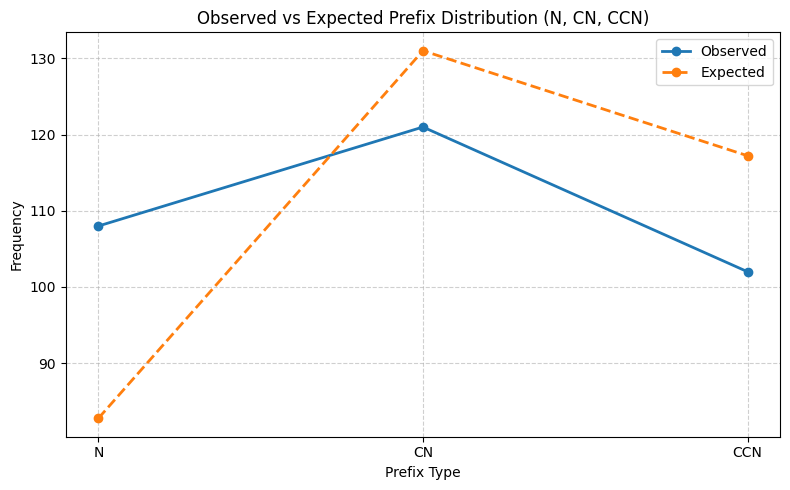

In [14]:
import matplotlib.pyplot as plt

# Labels for the x-axis
groups = ['N', 'CN', 'CCN']

# Observed prefix counts (from your output)
observed_prefix = [108, 121, 102]

# Expected counts (from design + spillover model)
expected_prefix = [82.75, 131.02, 117.23]

# Create plot
plt.figure(figsize=(8, 5))
plt.plot(groups, observed_prefix, marker='o', label='Observed', linewidth=2)
plt.plot(groups, expected_prefix, marker='o', linestyle='--', label='Expected', linewidth=2)

# Labels and formatting
plt.xlabel("Prefix Type")
plt.ylabel("Frequency")
plt.title("Observed vs Expected Prefix Distribution (N, CN, CCN)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Display
plt.show()


In [23]:
from collections import Counter
from scipy.stats import chisquare

# Initialize counts
prefix_counts = {
    'N': 0,
    'CN': 0,
    'CCN': 0,
    'C_end': 0,
    'CC_end': 0,
    'C...C': 0
}

for seq in sliced_sequences:
    prefix = seq[:10]
    first8 = prefix[:8]

    # Check for C...C first to exclude from other classes
    if first8[0] == 'C' and first8[-1] == 'C':
        prefix_counts['C...C'] += 1
    else:
        # Prefix classification
        if prefix.startswith('CC'):
            prefix_counts['CCN'] += 1
        elif prefix.startswith('C'):
            prefix_counts['CN'] += 1
        elif first8.endswith('CC'):
            prefix_counts['CC_end'] += 1
        elif first8.endswith('C'):
            prefix_counts['C_end'] += 1
        else:
            prefix_counts['N'] += 1

# Step 2: Observed counts
n_obs = prefix_counts['N']
cn_obs = prefix_counts['CN']
ccn_obs = prefix_counts['CCN']
nc_obs = prefix_counts['C_end']
ncc_obs = prefix_counts['CC_end']
cnc_obs = prefix_counts['C...C']

# Step 3: Expected counts based on design + spillover
total = n_obs + cn_obs + ccn_obs + nc_obs + ncc_obs + cnc_obs
x = total / 3  # designed fraction per group

n_exp = x * 0.4375
cn_exp = (x + (x * 0.1875)) * 0.75
ccn_exp = (x + (x * 0.0625)) * 0.75
nc_exp = x * 0.1875
ncc_exp = x * 0.0625
cnc_exp = (x * 0.0625) + ((x + (x * 0.1875)) * 0.25) + ((x + (x * 0.0625)) * 0.25)

# Step 4: Run chi-square test
stat, p = chisquare([n_obs, cn_obs, ccn_obs, nc_obs, ncc_obs, cnc_obs], f_exp=[n_exp, cn_exp, ccn_exp, nc_exp, ncc_exp, cnc_exp])

# Step 5: Output
print(f"\n📊 Chi-square test (prefix-based, design + spillover model):")
print(f"  Statistic = {stat:.2f}")
print(f"  P-value   = {p:.4g}")

print(f"\n📦 Observed counts:")
print(f"  N:   {n_obs}")
print(f"  CN:  {cn_obs}")
print(f"  CCN: {ccn_obs}")
print(f"  NC: {nc_obs}")
print(f"  NCC: {ncc_obs}")
print(f"  CNC: {cnc_obs}")

print(f"\n📈 Expected counts:")
print(f"  N:   {n_exp:.2f}")
print(f"  CN:  {cn_exp:.2f}")
print(f"  CCN: {ccn_exp:.2f}")
print(f"  NC: {nc_exp:.2f}")
print(f"  NCC: {ncc_exp:.2f}")
print(f"  CNC: {cnc_exp:.2f}")


📊 Chi-square test (prefix-based, design + spillover model):
  Statistic = 136.98
  P-value   = 7.857e-28

📦 Observed counts:
  N:   48
  CN:  52
  CCN: 55
  NC: 32
  NCC: 28
  CNC: 116

📈 Expected counts:
  N:   48.27
  CN:  98.27
  CCN: 87.92
  NC: 20.69
  NCC: 6.90
  CNC: 68.96


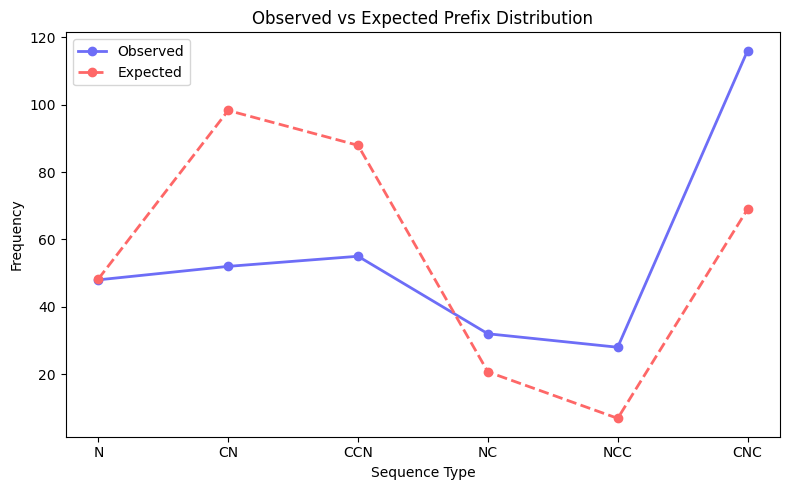

In [35]:
import matplotlib.pyplot as plt

# Labels
groups = ['N', 'CN', 'CCN', 'NC', 'NCC', 'CNC']
observed_prefix = [48, 52, 55, 32, 28, 116]
expected_prefix = [48.27, 98.27, 87.92, 20.69, 6.9, 68.96]

# Normalize RGB to [0,1]
group_colors_rgb = {
    2: (109/255, 109/255, 247/255),   # navy-ish
    4: (254/255, 103/255, 103/255)    # red-ish
}

# Create plot
plt.figure(figsize=(8, 5))
plt.plot(groups, observed_prefix, marker='o', label='Observed',
         linewidth=2, color=group_colors_rgb[2])
plt.plot(groups, expected_prefix, marker='o', linestyle='--', label='Expected',
         linewidth=2, color=group_colors_rgb[4])

# Labels and formatting
plt.xlabel("Sequence Type")
plt.ylabel("Frequency")
plt.title("Observed vs Expected Prefix Distribution")
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.savefig("C Obs vs Exp", dpi=300, bbox_inches="tight")

# Show plot
plt.show()
